In [56]:
from datetime import date
import matplotlib.pyplot as plt
import whittaker_smooth as ws
import numpy as np
import utils

# Data extraction


## Parameters

In [57]:
lat=  38.153600901211824
lon= -97.73950118113329
initial_date = date(2019, 4, 1)
location = "Kansas"
year = str(initial_date.year)
IMGS_PATH = ('D:\VSCode\Repositorios\Plant-Growth-Cycle-based-on-geospatial-data\DataExtraction\DataBase\\'+location+"-"+year)

## 1. Images extraction

In [58]:
band_labels = ["B4", "B3", "B2", "B8"]
images = utils.load_landsat_image(IMGS_PATH, band_labels)

#List of keys
img_keys = list(images.keys())

# Time information from images
days, timestamps_list, hours = utils.images_time_info(img_keys, initial_date)

## 2. Features extraction

In [59]:
start_dt = date.fromisoformat((min(timestamps_list)).strftime("%Y-%m-%d"))
end_dt = date.fromisoformat((max(timestamps_list)).strftime("%Y-%m-%d"))

# Temperature and precipitation database from ERA5 satellite
features_dict , date_dic = utils.temperature_precipitation_api(date_min=start_dt , date_max=end_dt , hours=hours)

# Extracted data transformed into a dictionary
temp_prec_dict = utils.data_extrator_temp(data_tp = features_dict,date_dict_api=date_dic )

# Get temperature and precipitation from specific dates (according to images dates)
temp,preci = utils.get_temp_and_preci(temp_prec_dict, timestamps_list)

# Optional, for values of all period of query (Normally from year/04/01 to year/11/01)
all_prec,all_temp = utils.values_temp_precip(dict_data=features_dict)

2022-11-30 18:32:58,551 INFO Welcome to the CDS
2022-11-30 18:32:58,553 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2022-11-30 18:32:58,956 INFO Request is completed
2022-11-30 18:32:58,957 INFO Downloading https://download-0004-clone.copernicus-climate.eu/cache-compute-0004/cache/data9/adaptor.mars.internal-1669829995.433229-8734-1-cfb99a8e-28cc-4616-8983-c753144a8088.nc to dataTemperatureCurrent.nc (3K)
2022-11-30 18:33:00,603 INFO Download rate 1.8K/s


# Polynomial regression
In this next section we develop the linear regression forecasting model.
1. NDVI data extraction
2. Features extraction (temperature, precipitation)
3. Building regression model and analysis based on 2019 data
4. Forecasting with 2020 features data

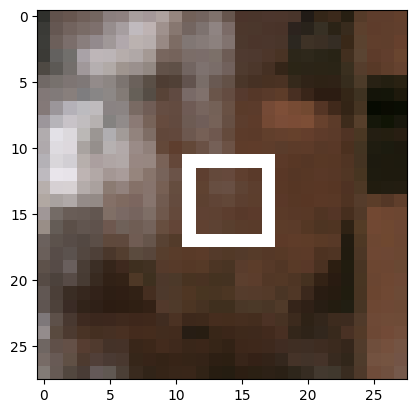

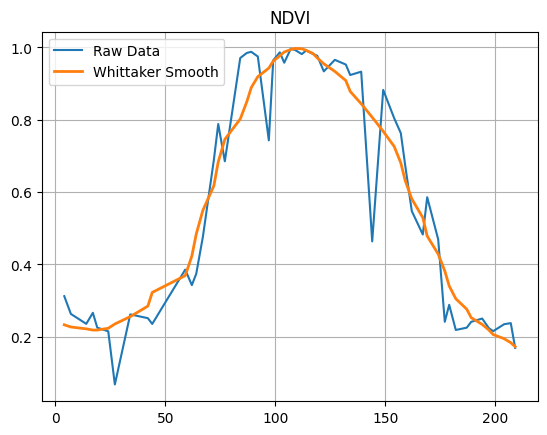

In [60]:
##NDVI
ndvi_ts = utils.generate_ndvi_time_series(images=images)

##NDVI curve smoothing
clean_ndvi = ws.whittaker_smooth(np.array(ndvi_ts),lmbd=100,d=2)

##Plotting 
plt.figure()
plt.plot(days,ndvi_ts,label="Raw Data") 
plt.plot(days,clean_ndvi,linewidth=2,label="Whittaker Smooth")
plt.title("NDVI")
plt.grid()
plt.legend()



## Curve smoothing

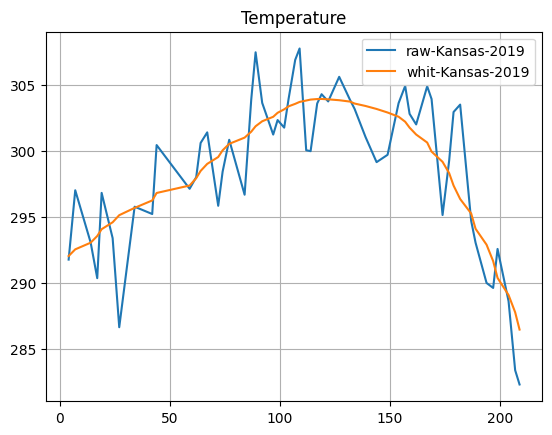

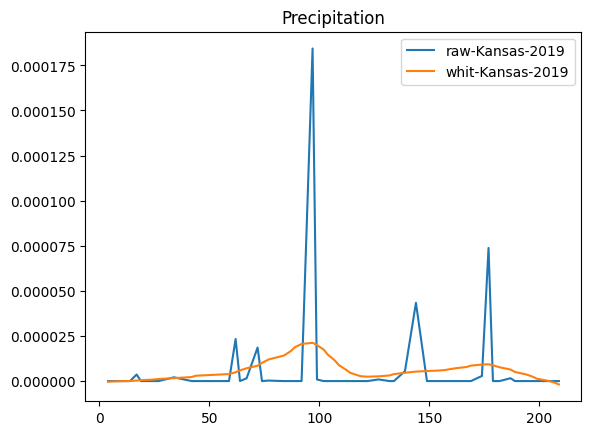

In [61]:
##Features curve smoothing
clean_temp = ws.whittaker_smooth(np.array(temp),lmbd=1000,d=2)
clean_preci = ws.whittaker_smooth(np.array(preci),lmbd=100,d=2)

plt.figure(1)
plt.title("Temperature")
plt.plot(days,temp,label='raw-'+location+'-'+year)
plt.plot(days,clean_temp,label='whit-'+location+'-'+year)
plt.grid()
plt.legend()

plt.figure(2)
plt.title("Precipitation")
plt.plot(days,preci,label='raw-'+location+'-'+year)
plt.plot(days,clean_preci,label='whit-'+location+'-'+year)
plt.legend()

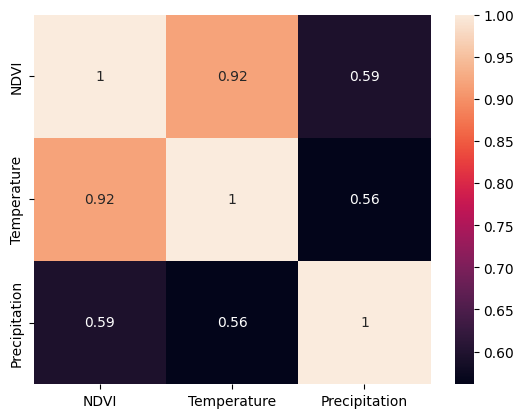

In [62]:
import pandas as pd
import seaborn as sn

data = {'NDVI': clean_ndvi,
        'Temperature': clean_temp,
        'Precipitation': clean_preci,
        }

df = pd.DataFrame(data)
corr_matrix = df.corr()
sn.heatmap(corr_matrix, annot=True)
plt.show()

## Model creation
Creation of a model based on 2019 temperature data.

(56,) (56, 1) (56,)
coefficient of determination: 0.9500163697781483
(56, 4)


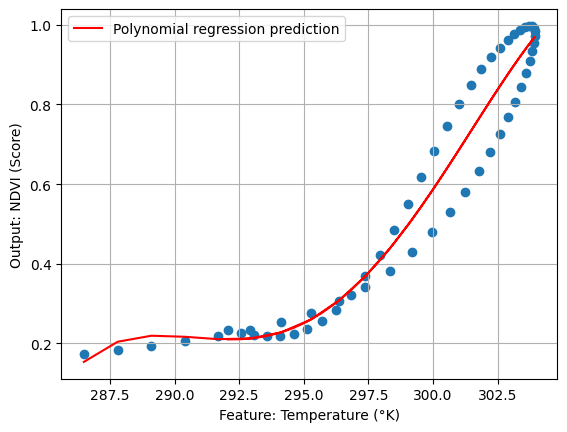

In [63]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Reshape to apply function (x must have a column per y value)
x = clean_temp.reshape((-1,1))
y = clean_ndvi
print(clean_temp.shape, x.shape, y.shape)
plt.figure()
plt.scatter(x,y)

# Transform to apply LinearRegression function
d = 4
transformer = PolynomialFeatures(degree=d, include_bias=False)
transformer.fit(x)
x_ = transformer.transform(x)

# Apply the model to our transformed x
model_2019 = LinearRegression().fit(x_, y)
y_predict = model_2019.predict(x_)


# Model score
r_sq = model_2019.score(x_, y)
print(f"coefficient of determination: {r_sq}")


plt.plot(x,y_predict,'r',label="Polynomial regression prediction")
plt.ylabel("Output: NDVI (Score)")
plt.xlabel("Feature: Temperature (°K)")
plt.grid()
plt.legend()

print(x_.shape)

## 4. Prediction trial for 2020 temperature (Validation)
Using model_2019 based to predict.

In [64]:

# IMPORTANTE: HARDCODEE PARA QUE FUERAN 56 VALORES, SE TIENEN QUE TENER MISMOS VALORES QUE EL MODELO (temp_2020 y model_2019)
# This data can be automatically obtain from features extraction section 
temp_2020 = np.array([283.1513671875, 289.03173828125, 
293.5457763671875, 291.2962646484375, 297.69195556640625, 294.6043395996094, 292.71337890625, 
292.75775146484375, 291.84521484375, 296.10162353515625, 298.845703125, 302.2131652832031, 
304.745361328125, 304.45263671875, 300.1196594238281, 303.5379638671875, 304.7825927734375, 
304.5750427246094, 301.0665588378906, 300.8268127441406, 305.9427795410156, 303.1600646972656, 
304.00531005859375, 304.8019104003906, 305.2742919921875, 303.05841064453125, 304.3760681152344, 
304.3102111816406, 304.8591613769531, 300.0223388671875, 295.9878234863281, 300.4503173828125, 
302.39495849609375, 299.494140625, 304.18853759765625, 302.7628173828125, 301.8044738769531, 
303.1278381347656, 304.5406799316406, 303.9774169921875, 299.01031494140625, 299.62939453125, 
303.2652587890625, 296.1610107421875, 298.5472412109375, 296.16888427734375, 297.0857238769531, 
299.902099609375, 293.60089111328125, 292.72198486328125, 292.0062561035156, 295.6786193847656, 
297.631103515625, 298.5773010253906, 296.42010498046875, 288.9350891113281])
x = temp_2020.reshape((-1,1))
transformer.fit(x)
x_ = transformer.transform(x)

y_2020 = model_2019.predict(x_)
prediction_ndvi_2020 = ws.whittaker_smooth(y_2020,lmbd=100)


# Prediction for year 2020 with comparison with real data

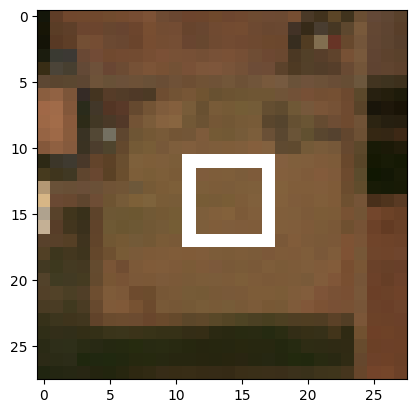

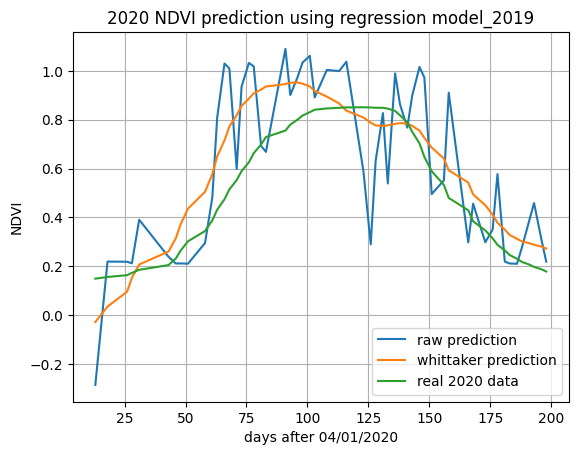

In [65]:

IMGS_PATH = ('D:\VSCode\Repositorios\Plant-Growth-Cycle-based-on-geospatial-data\DataExtraction\DataBase\\'+location+'-'+'2020')
band_labels = ["B4", "B3", "B2", "B8"]
images = utils.load_landsat_image(IMGS_PATH, band_labels)
img_keys = list(images.keys())
days,dates,hours = utils.images_time_info(img_keys,initial_date)

days=days[3:59]
#Calculations
##NDVI
real_ndvi_2020 = utils.generate_ndvi_time_series(images=images)[3:59]

##NDVI curve smoothing
real_ndvi_2020 = ws.whittaker_smooth(np.array(real_ndvi_2020),lmbd=100,d=2)


plt.figure()
plt.title("2020 NDVI prediction using regression model_2019")
plt.grid()
plt.plot(days,y_2020, label="raw prediction")
plt.plot(days,prediction_ndvi_2020, label = "whittaker prediction")
plt.plot(days,real_ndvi_2020, label = "real 2020 data")
plt.xlabel("days after 04/01/2020")
plt.ylabel("NDVI")
plt.legend()

In [66]:
print(mean_absolute_error(real_ndvi_2020,prediction_ndvi_2020))
print(mean_squared_error(real_ndvi_2020,prediction_ndvi_2020))

0.11300791483000203
0.017811209937635412


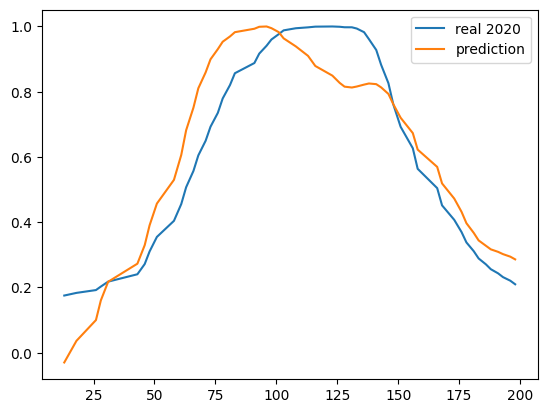

In [67]:
# Normalization
norm_real = [value/max(real_ndvi_2020) for value in real_ndvi_2020]
norm_pred = [value/max(prediction_ndvi_2020) for value in prediction_ndvi_2020]


plt.figure()
plt.plot(days,norm_real,label="real 2020")
plt.plot(days,norm_pred,label="prediction")
plt.legend()

## Prediction for year 2023 with model from 2019 data

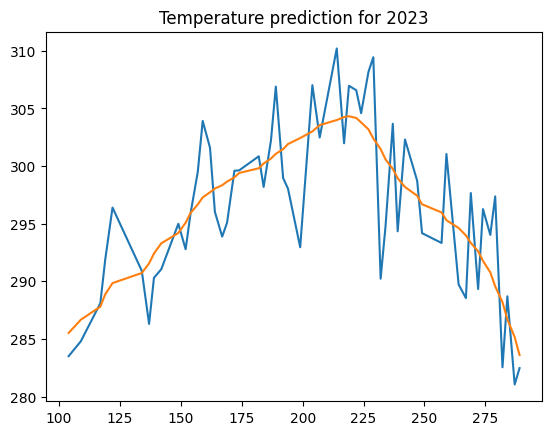

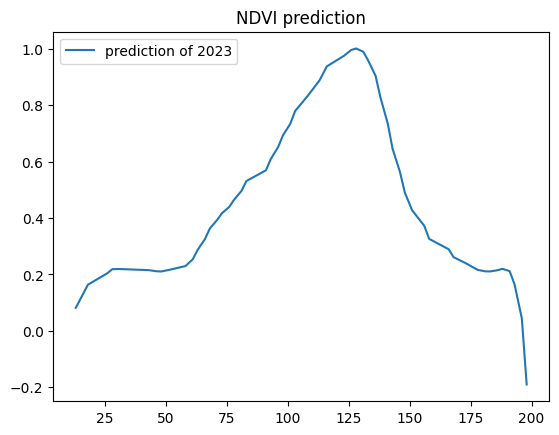

In [68]:
lat = lat
lon = lon

prediction_2022, prediction_2023 = utils.future_temperature_values(lat,lon)
initial_date_number = initial_date.timetuple().tm_yday         
days_after_04 = [day+initial_date_number for day in days]      
spec_temp_2023 = [prediction_2023[i] for i in days_after_04]    

clean_temp_2023 = ws.whittaker_smooth(np.array(spec_temp_2023),lmbd=100,d=2)


x = np.array(clean_temp_2023).reshape((-1,1))
transformer = PolynomialFeatures(degree=d, include_bias=False)
transformer.fit(x)
x_ = transformer.transform(x)

# Prediction of NDVI with model from 2019
y_2023 = model_2019.predict(x_)


plt.plot(days_after_04,spec_temp_2023)
plt.plot(days_after_04,clean_temp_2023)
plt.title("Temperature prediction for 2023")

plt.figure()
plt.plot(days,y_2023,label="prediction of 2023")
plt.title("NDVI prediction")
plt.legend()

In [69]:
# TODO: Changes these values for parameters on a database.
location = "Kansas"
BASE_DIR = ('D:\VSCode\Repositorios\Plant-Growth-Cycle-based-on-geospatial-data\DataExtraction\DataBase\\'+location)
bands =  ['B4','B3','B2','B8']

# Dictionaries of the images.
images_kansas19 = utils.load_landsat_image(BASE_DIR + '-2019', bands)
images_kansas20 = utils.load_landsat_image(BASE_DIR + '-2020', bands)
images_kansas21 = utils.load_landsat_image(BASE_DIR + '-2021', bands)
images_kansas22 = utils.load_landsat_image(BASE_DIR + '-2022', bands)

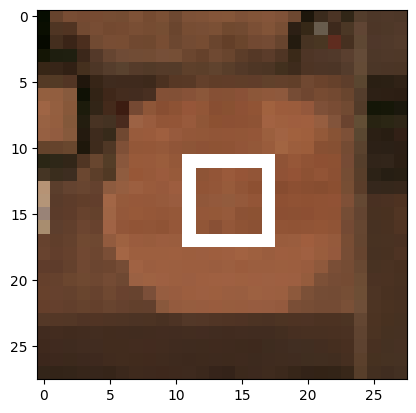

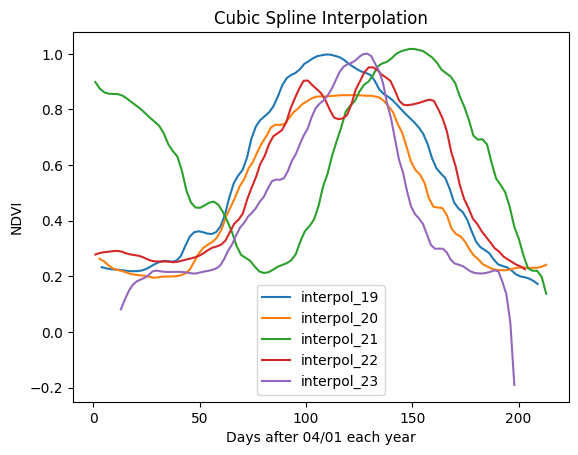

In [76]:
# Get the days after plant and the dates.
days_19, dates_19, hours_19 = utils.images_time_info(images_kansas19.keys(), initial_date = date(2019, 4, 1))
days_20, dates_20, hours_20 = utils.images_time_info(images_kansas20.keys(), initial_date = date(2020, 4, 1))
days_21, dates_21, hours_21 = utils.images_time_info(images_kansas21.keys(), initial_date = date(2021, 4, 1))
days_22, dates_22, hours_22 = utils.images_time_info(images_kansas22.keys(), initial_date = date(2022, 4, 1))

# Calculate the NDVI series over the crops.
ndvi_series_19 = utils.generate_ndvi_time_series(images_kansas19)
ndvi_series_20 = utils.generate_ndvi_time_series(images_kansas20)
ndvi_series_21 = utils.generate_ndvi_time_series(images_kansas21)
ndvi_series_22 = utils.generate_ndvi_time_series(images_kansas22)

# Apply a Whittaker Smooth filter.
ndvi_smooth_19 = ws.whittaker_smooth(np.array(ndvi_series_19), lmbd=100)
ndvi_smooth_20 = ws.whittaker_smooth(np.array(ndvi_series_20), lmbd=100)
ndvi_smooth_21 = ws.whittaker_smooth(np.array(ndvi_series_21), lmbd=100)
ndvi_smooth_22 = ws.whittaker_smooth(np.array(ndvi_series_22), lmbd=10)

# Apply an interpolation by splines.
x_19, y_19 = utils.interpolate_curve(days_19, ndvi_smooth_19)
x_20, y_20 = utils.interpolate_curve(days_20, ndvi_smooth_20)
x_21, y_21 = utils.interpolate_curve(days_21, ndvi_smooth_21)
x_22, y_22 = utils.interpolate_curve(days_22, ndvi_smooth_22)
x_23, y_23 = utils.interpolate_curve(days,y_2023)


plt.figure()
plt.plot(x_19, y_19, label='interpol_19')
plt.plot(x_20, y_20, label='interpol_20')
plt.plot(x_21, y_21, label='interpol_21')
plt.plot(x_22, y_22, label='interpol_22')
plt.plot(x_23,y_23, label='interpol_23')
plt.title('Cubic Spline Interpolation')
plt.xlabel('Days after 04/01 each year')
plt.ylabel('NDVI')
plt.legend()
plt.show()

In [72]:
def temperature_extraction(timestamps_list, hours):
    start_dt = date.fromisoformat((min(timestamps_list)).strftime("%Y-%m-%d"))
    end_dt = date.fromisoformat((max(timestamps_list)).strftime("%Y-%m-%d"))

    # Temperature and precipitation database from ERA5 satellite
    features_dict , date_dic = utils.temperature_precipitation_api(date_min=start_dt , date_max=end_dt , hours=hours)

    # Extracted data transformed into a dictionary
    temp_prec_dict = utils.data_extrator_temp(data_tp = features_dict,date_dict_api=date_dic )

    # Get temperature and precipitation from specific dates (according to images dates)
    temp,preci = utils.get_temp_and_preci(temp_prec_dict, timestamps_list)
    return np.array(temp)

In [86]:
lat = lat
lon = lon

# Temperature prediction from api
prediction_2022, prediction_2023 = utils.future_temperature_values(lat,lon)
initial_date_number = initial_date.timetuple().tm_yday         
days_after_04 = [day+initial_date_number for day in days]      
spec_temp_2022 = [prediction_2022[i] for i in days_after_04]    

clean_temp_2023 = ws.whittaker_smooth(np.array(spec_temp_2022),lmbd=10,d=2)

x = np.array(clean_temp_2022).reshape((-1,1))
transformer = PolynomialFeatures(degree=d, include_bias=False)
transformer.fit(x)
x_ = transformer.transform(x)
yprediction_2022 = model_2019.predict(x_)

MAE: 0.1736808943297744
RMSE: 0.0508136135482887


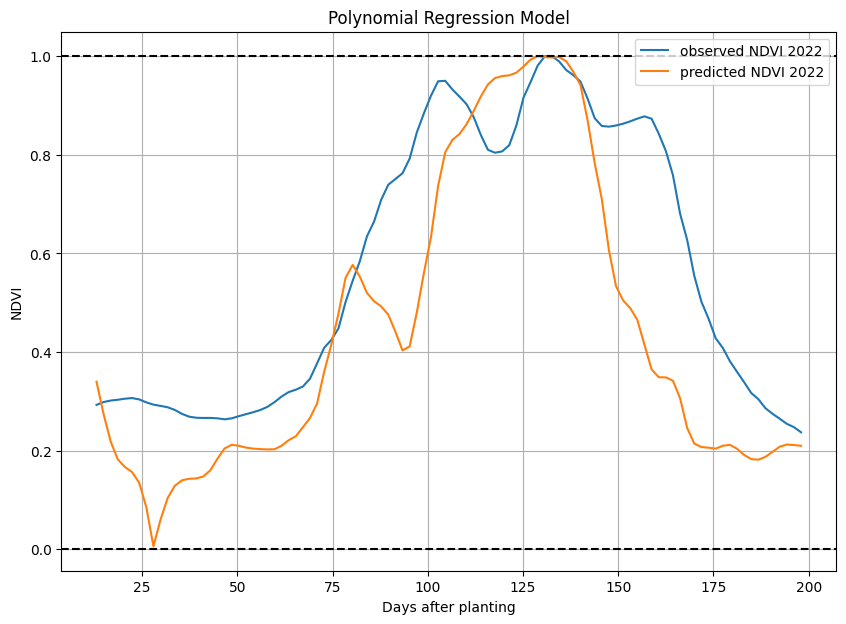

In [87]:
# Normalization
x_22, yprediction_22 = utils.interpolate_curve(days, yprediction_2022)
print(f'MAE: {mean_absolute_error(y_22,yprediction_22)}')
print(f'RMSE: {mean_squared_error(y_22,yprediction_22)}')

norm_real = [abs(value/max(y_22)) for value in y_22]
norm_pred = [abs(value/max(yprediction_22)) for value in yprediction_22]



plt.figure(figsize=(10, 7))
plt.plot(x_22,norm_real,label="observed NDVI 2022")
plt.plot(x_22,norm_pred,label="predicted NDVI 2022")
plt.axhline(y = 1, color = 'black', linestyle = '--')
plt.axhline(y = 0, color = 'black', linestyle = '--')
plt.title('Polynomial Regression Model')
plt.xlabel('Days after planting')
plt.ylabel('NDVI')
plt.legend(loc='upper right')
plt.grid()
plt.show()


MAE: 0.1736808943297744
RMSE: 0.0508136135482887


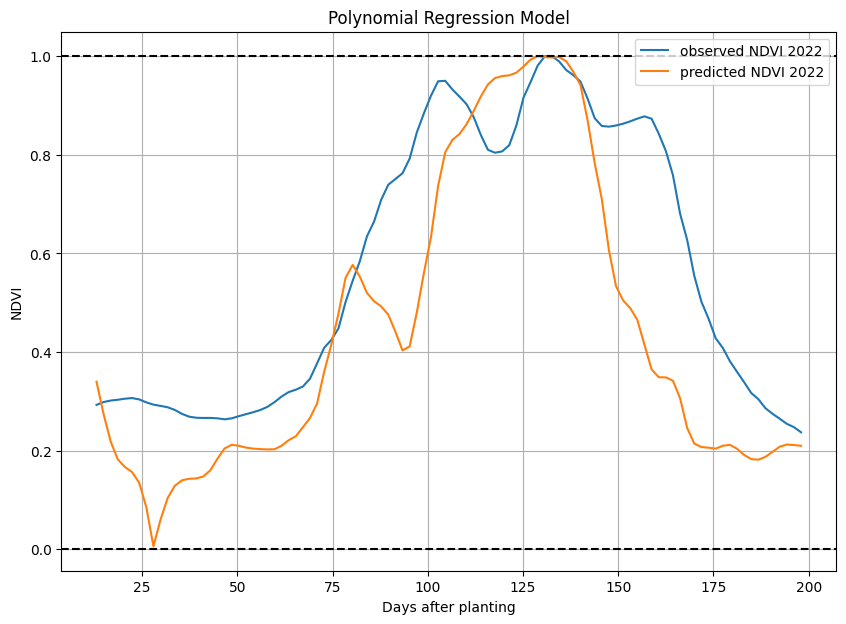

In [87]:
# Normalization
x_22, yprediction_22 = utils.interpolate_curve(days, yprediction_2022)
print(f'MAE: {mean_absolute_error(y_22,yprediction_22)}')
print(f'RMSE: {mean_squared_error(y_22,yprediction_22)}')

norm_real = [abs(value/max(y_22)) for value in y_22]
norm_pred = [abs(value/max(yprediction_22)) for value in yprediction_22]



plt.figure(figsize=(10, 7))
plt.plot(x_22,norm_real,label="observed NDVI 2022")
plt.plot(x_22,norm_pred,label="predicted NDVI 2022")
plt.axhline(y = 1, color = 'black', linestyle = '--')
plt.axhline(y = 0, color = 'black', linestyle = '--')
plt.title('Polynomial Regression Model')
plt.xlabel('Days after planting')
plt.ylabel('NDVI')
plt.legend(loc='upper right')
plt.grid()
plt.show()
